### The Hopenhayn 1992 Industry Equilibrium Model

Seho Jeong, Sogang University

References:
- **Sargent, Thomas J. and John Stachurski. n.d.** "The Hopenhayn Entry-Exit Model." Quantitative Economics with JAX. https://jax.quantecon.org/hopenhayn.html.

In [9]:
import numpy as np
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt
import seaborn as sns

from collections import namedtuple
from functools import partial

import quantecon as qe

In [2]:
jax.config.update('jax_enable_x64', True)

In [3]:
# Define customized colormap for plots.
cm = ['#116FA1', '#2DC0D2', '#E0B266', '#00979F', '#70CAC6', '#005A7D']
bg = '#F9F9F9'

In [5]:
Parameters = namedtuple('Parameters', ['β',    # discount factor
                                       'θ',    # labor productivity
                                       'c_f',  # fixed operation cost
                                       'c_e',  # entry cost
                                       'w',    # wages
                                       'μ_a',  # productivity shock location parameter
                                       'σ_a',  # productivity shock scale parameter
                                       'μ_e',  # entrants location parameter
                                       'σ_e']) # entrants scale parameter 

Arrays = namedtuple('Arrays', ['zgrid',        # productivity grid
                               'E_draws',      # entry size draws for Monte Carlo
                               'A_draws'])     # productivity shock draws for Monte Carlo

Model = namedtuple('Model', ['parameters',     # instance of Parameters
                             'arrays'])        # instance of Arrays

In [48]:
def create_hopenhayn1992_model(β=0.95,          # discount factor
                               θ=0.3,           # labor productivity
                               c_f=4.0,         # fixed cost in production
                               c_e=1.0,         # entry cost
                               w=1.0,           # wages
                               μ_a=-0.012,      # productivity shock location parameter
                               σ_a=0.1,         # productivity shock scale parameter
                               μ_e=1.0,         # entrants location parameter
                               σ_e=0.2,         # entrants scale parameter
                               zmin=0.0,        # min. of productivity grid
                               zmax=5.0,          # max. of productivity grid
                               znum=100,        # num. of grid points for productivity
                               E_draw_size=200, # entry MC integration size
                               A_draw_size=200, # productivity shock MC integration size
                               seed=101):       # seed for MC draws
    """ 
    Create an instance of the namedtuple `Model`.
    """
    # Test the stability.
    assert μ_a + σ_a ** 2 / (2 * (1 - θ)) < 0, 'Stabiilty condition fails.'

    # Build grids and initialize a random number generator.
    zgrid = jnp.linspace(zmin, zmax, znum)
    key, subkey = jax.random.split(jax.random.PRNGKey(seed))

    # Generate a sample of draws of A for Monte Carlo integration.
    A_draws = jnp.exp(μ_a + σ_a * jax.random.normal(key, (A_draw_size, )))

    # Generate a sample of draws from γ for Monte Carlo integration.
    E_draws = jnp.exp(μ_e + σ_e * jax.random.normal(subkey, (E_draw_size, )))

    # Build the `Model` and return.
    parameters = Parameters(β, θ, c_f, c_e, w, μ_a, σ_a, μ_e, σ_e)
    arrays = Arrays(zgrid, E_draws, A_draws)
    model = Model(parameters, arrays)

    return model

In [8]:
# Write down functions for profits and outputs.

@jax.jit
def π(z, p, parameters):
    """ 
    Profits for a firm
    """
    # Unpack parameters.
    β, θ, c_f, c_e, w, μ_a, σ_a, μ_e, σ_e = parameters

    # Compute profits from the static profit maximization problem.
    return (1 - θ) * (p * z) ** (1 / (1 - θ)) * (θ / w) ** (θ / (1 - θ)) - c_f

@jax.jit
def q(z, p, parameters):
    """ 
    Output for a firm.
    """
    # Unpack parameters.
    β, θ, c_f, c_e, w, μ_a, σ_a, μ_e, σ_e = parameters

    # Compute outputs from the static profit maximization problem.
    return z ** (1 / (1 - θ)) * (p * θ / w) ** (θ / (1 - θ))

In [10]:
@partial(jax.jit, static_argnums=(4, ))
def update_cross_section(z_bar, z_vec, key, parameters, num_firms):

    # Unpack parameters.
    β, θ, c_f, c_e, w, μ_a, σ_a, μ_e, σ_e = parameters

    # Update.
    Z = jax.random.normal(key, (2, num_firms))
    incumbent_draws = z_vec * jnp.exp(μ_a + σ_a * Z[0, :])
    entrant_draws = z_vec * jnp.exp(μ_e + σ_e * Z[1, :])

    return jnp.where(z_vec >= z_bar, incumbent_draws, entrant_draws)

In [11]:
def simulate_firms(z_bar, parameters, arrays, sim_length=200, num_firms=1_000_000, seed=12):
    """ 
    Simulate a cross-section of firms when the exit threshold is z_bar.
    """
    # Set initial conditions to the threshold value.
    z_vec = jnp.ones((num_firms, )) * z_bar
    key = jax.random.PRNGKey(seed)

    # Iterate forward in time.
    for ti in range(sim_length):
        key, subkey = jax.random.split(key)
        z_vec = update_cross_section(z_bar, z_vec, subkey, parameters, num_firms)
    
    return z_vec

In [13]:
@jax.jit
def _compute_exp_value_at_z(V, z, arrays):
    """ 
    Compute

        E[V(z')|z] = E[V(Az)]

    using linear interpolation and Monte Carlo.
    """
    # Unpack arrays.
    zgrid, E_draws, A_draws = arrays

    # Set up V.
    Az = A_draws * z
    VAz = jnp.interp(Az, zgrid, V) # V(A_j z) for all j
    
    # Return mean.
    return jnp.mean(VAz) # (1 / n) Σ_j V(A_j z)

compute_exp_value_at_z = jax.vmap(_compute_exp_value_at_z, in_axes=(None, 0, None))

@jax.jit
def compute_exp_value(V, arrays):
    """ 
    Compute
    
        E[V(z')|z] = E[V(Az)] for all z, as a vector.
    """
    # Unpack arrays.
    zgrid, E_draws, A_draws = arrays
    return compute_exp_value_at_z(V, zgrid, arrays)

In [14]:
@jax.jit
def T(V, p, parameters, arrays):
    """ 
    Bellman operator
    """
    # Unpack parameters and arrays.
    β, θ, c_f, c_e, w, μ_a, σ_a, μ_e, σ_e = parameters
    zgrid, E_draws, A_draws = arrays

    # Compute TV.
    EVAz = compute_exp_value(V, arrays)
    return π(zgrid, p, parameters) + β * jnp.maximum(0.0, EVAz)

In [15]:
@jax.jit
def get_threshold(V, arrays):
    """ 
    Compute the exit threshold.
    """
    # Unpack arrays.
    zgrid, E_draws, A_draws = arrays

    # Compute the exit threshold, i.e., z s.t. E[V(z')|z] = 0.
    EVAz = compute_exp_value(V, arrays)
    idx = jnp.searchsorted(EVAz, 0.0)
    return zgrid[idx]

In [28]:
@jax.jit
def value_function_iteration(p, V_init, parameters, arrays, tol=1e-6, max_iter=10_000):
    """ 
    Implement the value function iteration to solve for the value function.
    """
    # Unpack arrays.
    zgrid, E_draws, A_draws = arrays

    # Set up.
    def cond_function(state):
        iteration, V, error = state
        return jnp.logical_and(iteration < max_iter, error > tol)
    
    def body_function(state):
        iteration, V, error = state
        V_new = T(V, p, parameters, arrays)
        error = jnp.max(jnp.abs(V - V_new))
        iteration += 1
        return iteration, V_new, error
    
    # Loop till convergence.
    init_state = 0, V_init, tol + 1
    state = jax.lax.while_loop(cond_function, body_function, init_state)
    iteration, V, error = state
    return V

In [18]:
@jax.jit
def compute_net_entry_value(p, V_init, parameters, arrays):
    """ 
    Returns the net value of entry, which is

        ∫ V*(z, p) γ(dz) - c_e

    This is the break-even condition for new entrants.
    The argument V_init is used as an initial condition when computing V* for VFI.
    """
    # Unpack parameters and arrays.
    β, θ, c_f, c_e, w, μ_a, σ_a, μ_e, σ_e = parameters
    zgrid, E_draws, A_draws = arrays

    V_star = value_function_iteration(p, V_init, parameters, arrays)
    V_z = jnp.interp(E_draws, zgrid, V_star)
    EV_z = jnp.mean(V_z)
    return EV_z - c_e, V_star

In [20]:
def compute_p_star(parameters, arrays, pmin=1.0, pmax=2.0, tol=1e-5):
    """
    Compute the equilibrium entry price p* via bisection.
    Return both p* and the corresponding value function V*, which is computed as a byproduct.
    Implements the bisection root finding algorithm to find p*.
    """
    # Unpack arrays.
    zgrid, E_draws, A_draws = arrays

    lower, upper = pmin, pmax
    V_star = jnp.zeros_like(zgrid) # initial condition at first price guess.

    while upper - lower > tol:
        mid = 0.5 * (upper + lower)
        entry_val, V_star = compute_net_entry_value(mid, V_star, parameters, arrays)
        if entry_val > 0: 
            # Root is between lower and mid.
            lower, upper = lower, mid
        else: 
            # Root is between mid and upper.
            lower, upper = mid, upper

    p_star = 0.5 * (upper + lower)
    return p_star, V_star

In [21]:
def compute_equilibrium_prices_and_quantities(model):
    """
    Compute

        1. The equilibrium outecomes for p*, V*, and z*, wehre z* is the equilibrium exit threshold z_bar(p*).
        2. The scaling factor necessary to convert the stationary probability distribution μ into the equilibrium firms distribution μ* = sμ.
        3. The equilibrium mass of entrants M* = μ*({z < z*})
    """
    # Unpack the model.
    parameters, arrays = model

    # Compute prices and values.
    p_star, V_star = compute_p_star(parameters, arrays)

    # Get z_star = z_bar(p_star), the equilibrium exit threshold.
    z_star = get_threshold(V_star, arrays)

    # Generate an array of draws from μ, the normalized stationary distribution.
    z_sample = simulate_firms(z_star, parameters, arrays)

    # Compute s to scale μ.
    demand = 1 / p_star
    pre_normalized_supply = jnp.mean(q(z_sample, p_star, parameters))
    s = demand / pre_normalized_supply

    # Compute M* = μ*({z < z*}).
    M_star = s *  jnp.mean(z_sample < z_star)

    return p_star, V_star, z_star, z_sample, s, M_star

In [26]:
# Create an instance of the model.
model = create_hopenhayn1992_model()
parameters, arrays = model

In [33]:
p = 2.0
V_init = jnp.zeros_like(arrays.zgrid)
%time V_star = value_function_iteration(p, V_init, parameters, arrays).block_until_ready()

CPU times: user 14.5 ms, sys: 2.57 ms, total: 17.1 ms
Wall time: 8.58 ms


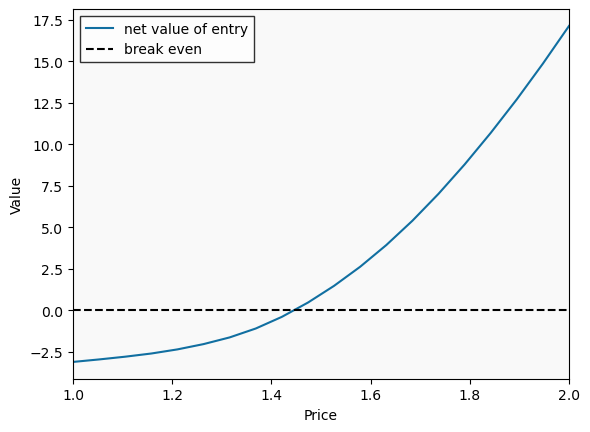

In [41]:
pmin, pmax, pnum = 1.0, 2.0, 20
p_vec = jnp.linspace(pmin, pmax, pnum)

entry_vals = []
V_star = jnp.zeros_like(arrays.zgrid) # initial condition at first price guess

for i, p in enumerate(p_vec):
    entry_val, V_star = compute_net_entry_value(p, V_star, parameters, arrays)
    entry_vals.append(entry_val)

# Plot the equilibrium price at given parameters.
fig, ax = plt.subplots()

ax.plot(p_vec, entry_vals, label='net value of entry', color=cm[0])
ax.axhline(0, color='k', ls='--', label='break even')

ax.legend(fancybox=False, edgecolor='k')
ax.set_facecolor(bg)
ax.set_xmargin(0)
ax.set_xlabel('Price')
ax.set_ylabel('Value')

plt.show()

In [43]:
%%time
# Compute the equilibrium.
p_star, V_star, z_star, z_sample, s, M_star = compute_equilibrium_prices_and_quantities(model)

CPU times: user 13.1 s, sys: 581 ms, total: 13.7 s
Wall time: 1.52 s


In [45]:
print(p_star)

1.4457054138183594


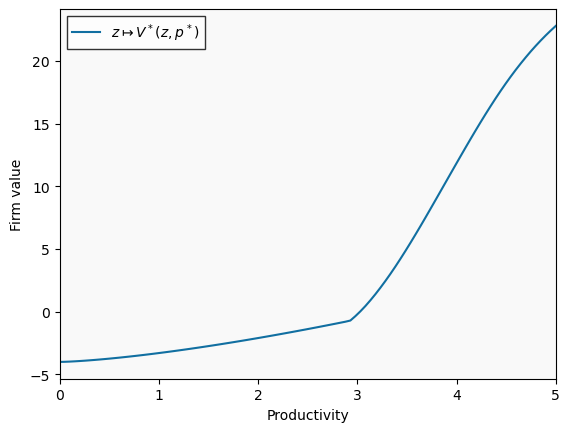

In [47]:
fig, ax = plt.subplots()

ax.plot(arrays.zgrid, V_star, label=r'$z \mapsto V^*(z, p^*)$', color=cm[0])

ax.legend(fancybox=False, edgecolor='k')
ax.set_facecolor(bg)
ax.set_xmargin(0)
ax.set_xlabel('Productivity')
ax.set_ylabel('Firm value')

plt.show()

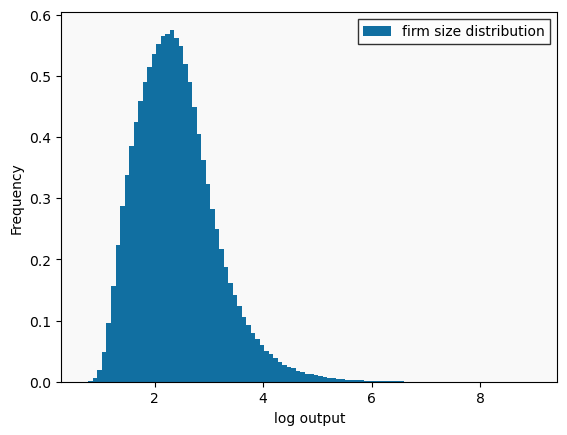

In [56]:
# Plot the firm size distribution.

output_dist = q(z_sample, p_star, parameters)

fig, ax = plt.subplots()

ax.hist(jnp.log(output_dist), bins=100, density=True, label='firm size distribution', color=cm[0])

ax.legend(fancybox=False, edgecolor='k')
ax.set_facecolor(bg)
ax.set_xlabel('log output')
ax.set_ylabel('Frequency')

plt.show()